# OpenDartReader를 활용한 계정 추출

In [1]:
# 라이브러리 설치 (최초 1회)
#!pip install opendartreader pandas matplotlib

#글꼴 깨지는 경우
#1.나눔고딕 글꼴 설치
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm -rf ~/.cache/matplotlib
#2.런타임 > 런타임 다시시작을 선택, 런타임을 재시작.

import OpenDartReader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Open DART API Key
api_key='Enter your API key here'
dart = OpenDartReader(api_key)

# Matplotlib 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

조회할 기업명 또는 종목코드를 입력하세요(대소문자구별): RF머트리얼즈
01343665

검색된 기업 목록:
01343665
<class 'str'>

최근 몇 년도 재무제표를 조회하시겠습니까? (예: 5): 7
연결 또는 개별 재무제표를 선택하세요 (연결/개별): 연결
데이터 수집 중: 2025년
{'status': '013', 'message': '조회된 데이타가 없습니다.'}

데이터 수집 중: 2024년
데이터 수집 중: 2023년
데이터 수집 중: 2022년
데이터 수집 중: 2021년
데이터 수집 중: 2020년
데이터 수집 중: 2019년

추이를 확인할 수 있는 계정 목록:
['유동자산' '비유동자산' '자산총계' '유동부채' '비유동부채' '부채총계' '자본금' '이익잉여금' '자본총계' '매출액'
 '영업이익' '법인세차감전 순이익' '당기순이익' '파생상품자산' '당기순이익(손실)' '총포괄손익']

추이를 확인할 계정명을 입력하세요 (예: 자산총계): 당기순이익

'당기순이익' 연도별 값:
2019            NaN
2020    -232.825713
2021    -370.511762
2022    3562.334693
2023     714.080665
2024   -7582.837040
2025            NaN
dtype: float64 단위:백만원


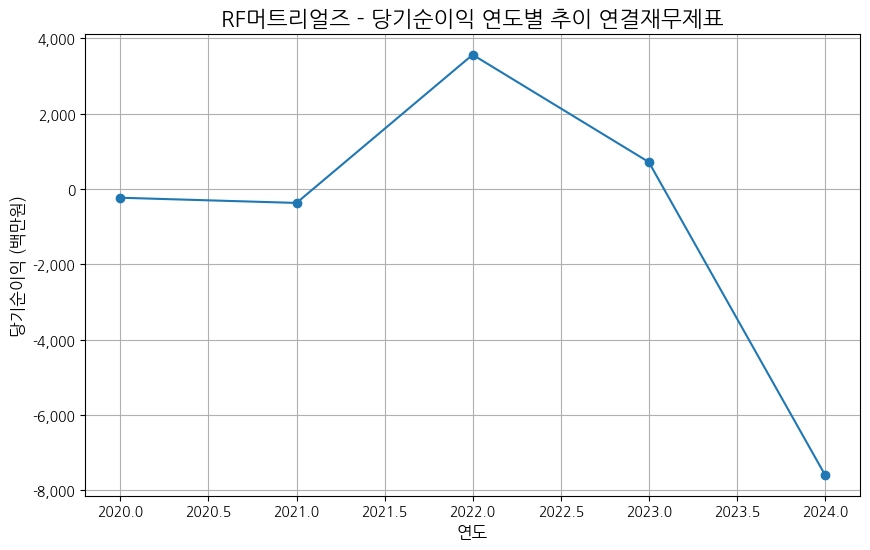

In [5]:
def main_process():
    # 1. 기업명 또는 종목코드로 고유번호(corp_code) 찾기
    while True:
        try:
            corp_input = input("조회할 기업명 또는 종목코드를 입력하세요(대소문자구별): ")
            corp_list = dart.find_corp_code(corp_input)
            print(corp_list)

            if corp_list is None:
                print("입력한 기업명이 존재하지 않습니다. 다시 입력해주세요.")
                continue

            print("\n검색된 기업 목록:")
            print(corp_list)
            print(type(corp_list))
            break

        except ValueError:
            print("숫자를 올바르게 입력해주세요.")
        except Exception as e:
            print(f"오류가 발생했습니다: {e}")

    # 2. 최근 N년도 재무제표 얻기 (연결/개별 재무제표 선택 가능)
    while True:
        try:
            num_years = int(input("\n최근 몇 년도 재무제표를 조회하시겠습니까? (예: 5): "))
            fs_type = input("연결 또는 개별 재무제표를 선택하세요 (연결/개별): ")

            if fs_type not in ['연결', '개별']:
                print("잘못된 재무제표 종류입니다. '연결' 또는 '개별'을 입력해주세요.")
                continue

            if fs_type == '연결':
                fs_nm = fs_type + '재무제표'
            else:
                fs_nm = '재무제표'

            # 최근 n년도 데이터 수집
            current_year = datetime.now().year
            all_dfs = []
            for i in range(num_years):
                year = current_year - i
                print(f"데이터 수집 중: {year}년")

                # finstate 호출 시 오류 발생 가능성 고려 (try-except)
                try:
                    df_year = dart.finstate(corp_list, year)

                    if df_year is not None:
                        all_dfs.append(df_year)
                    else:
                        print(f"경고: {year}년도 데이터가 없습니다. (계속 진행)")
                except Exception as e:
                    print(f"경고: {year}년도 데이터 수집 중 오류 발생 - {e} (계속 진행)")

            if not all_dfs:
                print("조회 가능한 재무제표 데이터가 없습니다. 프로그램을 종료합니다.")
                return

            finstate_df = pd.concat(all_dfs, ignore_index=True)
            break

        except ValueError:
            print("올바른 숫자를 입력해주세요.")
        except Exception as e:
            print(f"오류가 발생했습니다: {e}")
            return

    # 3. 원하는 계정의 값을 'thstrm_amount'에서 추출
    while True:
        try:
            # 계정명이 하나도 없다면 종료
            if finstate_df['account_nm'].empty:
                print("재무제표에 계정 정보가 없습니다. 프로그램을 종료합니다.")
                return

            print("\n추이를 확인할 수 있는 계정 목록:")
            unique_count=finstate_df['account_nm'].unique()
            print(unique_count)
            account_name = input("\n추이를 확인할 계정명을 입력하세요 (예: 자산총계): ")
            account_data = finstate_df[(finstate_df['account_nm'] == account_name) & (finstate_df['fs_nm']==fs_nm)]
            # `.copy()`를 사용하여 독립적인 사본을 만듭니다.
            account_data = finstate_df[(finstate_df['account_nm'] == account_name) & (finstate_df['fs_nm']==fs_nm)].copy()

            if account_data.empty:
                print("입력하신 계정명이 재무제표에 존재하지 않습니다. 다시 입력해주세요.")
                continue
            ## 'thstrm_amount' 열을 숫자형으로 변환
            # errors='coerce'를 사용하면 변환할 수 없는 값은 NaN으로 바뀝니다.
            account_data['thstrm_amount'] = pd.to_numeric(account_data['thstrm_amount'].astype(str).str.replace(',', ''),
errors='coerce')

            # 6. 없는 연도는 그대로 나타내기 위해 NaN 값 처리
            years = [datetime.now().year - i for i in range(num_years)]
            result_series = pd.Series(index=years)
            for _, row in account_data.iterrows():
                result_series[int(row['bsns_year'])] = row['thstrm_amount']

            result_series.sort_index(inplace=True)
            rounded_series = (result_series / 1_000_000)
            print(f"\n'{account_name}' 연도별 값:")
            print(rounded_series,"단위:백만원")
            break

        except Exception as e:
            print(f"오류가 발생했습니다: {e}이 존재하지 않음")
            break

    # 4. 연도별 추이 그래프로 시각화
    plt.figure(figsize=(10, 6))
    # Y축 단위를 쉼표(,)를 포함한 전체 숫자로 표시
    import matplotlib.ticker as ticker
    def comma_formatter(x, pos):
        return f'{x:,.0f}'
    formatter = ticker.FuncFormatter(comma_formatter)
    plt.gca().yaxis.set_major_formatter(formatter)

    #나머지설정
    rounded_series.plot(kind='line', marker='o')
    plt.title(f"{corp_input} - {account_name} 연도별 추이 {fs_nm}", fontsize=16)
    plt.xlabel('연도', fontsize=12)
    plt.ylabel(f'{account_name} (백만원)', fontsize=12)
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main_process()

In [ ]:
df_year = dart.finstate('SK', 2023)
print(df_year)


{'status': '013', 'message': '조회된 데이타가 없습니다.'}

Empty DataFrame
Columns: []
Index: []
